In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

In [2]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def get_model_df(df, X_COLS, Y_COL, NAIVE_COL):
    cols = ['Date', 'Fips'] + X_COLS + [Y_COL, NAIVE_COL]
    df = df[cols]    
    return df

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):    
    X_train = df_train[X_COLS]
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    
    df_pred = df_test.copy()
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return df_pred

## <font color=blue> 1) Dataset

In [37]:
from epsampling.utils import drop_duplicate_cols
ts = '20241108-123515'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
df = pd.read_csv(fpath)
df = df[df.True_county_inc_deaths >= 0]
display(df.columns)

fpath = os.path.join(DATA_DIR,'processed',f'training_acs_df_{ts}.csv')
df_acs = pd.read_csv(fpath)
df_acs.set_index('Fips',inplace=True)
df = df.join(df_acs,on='Fips')

# # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # 

Y_COL = 'True_county_inc_deaths'

tvarying_cols = ['True_county_inc_deaths_tm_4','True_county_inc_deaths_tm_5',
                 'True_county_inc_deaths_tm_6','True_county_inc_deaths_tm_7','True_county_inc_deaths_tm_8']
X_COLS = ['Ratio','Proj_state_inc_deaths','Pop'] + list(df_acs.columns) + tvarying_cols
# remove redundant covariates
to_remove = ['POP', 'POP_x3', 'HH_x6', 'POP_16p_EMP_x8', 'IND_CONS_x8', 
                  'IND_MAN_x8', 'IND_WHT_x8', 'IND_RETT_x8', 'IND_INF_x8', 
                  'IND_OSER_x8', 'IND_PUBA_x8', 'POP_16p_EMP_x10', 'POP_16p_EMP_x11',
                  'POP_16p_EMP', 'OCC_SERV_HCS_x12', 'OCC_SERV_FPS_x12', 
                  'OCC_SERV_BGM_x12', 'OCC_SERV_PCS_x12', 'OCC_SALES_SR_x12', 
                  'OCC_SALES_OAS_x12', 'OCC_NRCM_FFF_x12', 'OCC_NRCM_CE_x12', 
                  'OCC_NRCM_IMR_x12', 'OCC_PTMM_P_x12', 'OCC_PTMM_T_x12', 
                  'OCC_PTMM_MM_x12', 'POP_x13', 'POP_HISP_x13', 'POP_x14', 'HU_x15']
for x in to_remove:
    X_COLS.remove(x)
# X_COLS = ['Proj_state_inc_deaths', 'Pop']
# print(len(X_COLS))

NAIVE_COL = 'Naive_proj_deaths'

df.dropna(inplace=True)

df = df[df['True_county_inc_deaths'] >= 0]

Index(['Date', 'State_fips', 'Fips', 'Pop', 'State_pop', 'Ratio',
       'Proj_state_inc_deaths', 'True_state_inc_deaths',
       'True_county_cum_deaths', 'True_county_inc_deaths', 'Naive_proj_deaths',
       'Naive_true_deaths', 'True_county_inc_deaths_tm_4',
       'True_county_inc_deaths_tm_5', 'True_county_inc_deaths_tm_6',
       'True_county_inc_deaths_tm_7', 'True_county_inc_deaths_tm_8',
       'True_county_inc_deaths_tm_9', 'True_county_inc_deaths_tm_10',
       'True_county_inc_deaths_tm_11'],
      dtype='object')

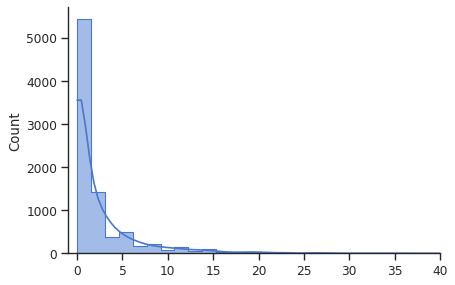

Are all targets non-negative? True


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 
DPI = 80
FIGSIZE = (6,4)

plt.figure(figsize=FIGSIZE)
sns.histplot(df[Y_COL].values, bins=60, kde=True, element='step')
sns.despine()
plt.xlim((-1, 40))
plt.gcf().set_dpi(DPI)
plt.show()

print(f"Are all targets non-negative? {(df[Y_COL].min() >= 0)}")

## <font color=blue> 2) Modeling
- <font color=blue> **_Train-test split:_** Our training and test/evaluation set will be partitioned based on (2 month)-wise chunks. That is, we will evaluate our model on temporally consecutive targets over the course of 8 weeks, and we will train on the remaining weeks.
    - <font color=black> **Train samps:** 7939
    - <font color=black> **Test samps:** 771
- <font color=blue> **_Cross validation protocol:_** We will train a model for each month, for a total of 10 models. From these, we can evaluate average performance for each regression algorithm.
    

In [39]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklego.meta import ZeroInflatedRegressor as zir_model
from sklearn.svm import SVC
import statsmodels.api as sm

from catboost import CatBoostRegressor, Pool

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):  
    scaler = StandardScaler()
    X_train = df_train[X_COLS]
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    X_test = scaler.transform(X_test)

    df_pred = df_test.copy()
    
    if ALG=='NegBinomial':
        X_train = sm.add_constant(X_train)
        reg = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=0.5)).fit()
        df_pred['Algorithm'] = ALG
        X_test = sm.add_constant(X_test)
        df_pred[PRED_COL] = reg.predict(X_test)
        return reg, df_pred
    if ALG=='Linear':
        reg = linear_model.LinearRegression().fit(X_train, y_train)
    if ALG=='Poisson':
        reg = linear_model.PoissonRegressor().fit(X_train, y_train)
    elif ALG=='ZIR':
        reg = zir_model(
            classifier=SVC(),
            regressor=linear_model.LinearRegression()).fit(X_train, y_train) 
            
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return reg, df_pred



res_dfs = []
regs = []
models = {}
chunks = get_chunks(list(df.Date.unique()), num_membs=8)

my_algs = ['Linear', 'Poisson', 'NegBinomial', 'Naive']
for ALG in my_algs:
    for i,test_chunk in tqdm(enumerate(chunks), total=len(chunks)):

        df_train, df_test = get_date_chunked_splits(df, chunks, i)
        
        df_test[f'Run'] = i
        PRED_COL = 'PRED county deaths' 
        
        if ALG=='Naive':
            df_res = df_test
            df_res['Algorithm'] = 'Naive'
            df_res[PRED_COL] = df_res[NAIVE_COL]
        else:
            PRED_COL = 'PRED county deaths'   
            reg, df_res = get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL=PRED_COL, ALG=ALG)
            regs.append(reg)

        res_dfs.append(df_res)
    
df_full_res = pd.concat(res_dfs)
display(df_full_res)

100%|██████████| 11/11 [00:00<00:00, 220.20it/s]


,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,...,HU_UIS0304,HU_UIS0509,HU_UIS1019,HU_UIS2049,HU_UIS50P,HU_UISOTHER,Naive_delta,Run,Algorithm,PRED county deaths
11,20200905,37,37001,169185,10367022,0.016320,157.0,205.0,46.0,0.0,...,0.03587,0.049194,0.034728,0.029084,0.011507,0.116007,2.562167,0,Linear,4.441346
12,20200912,37,37001,169185,10367022,0.016320,176.0,160.0,48.0,2.0,...,0.03587,0.049194,0.034728,0.029084,0.011507,0.116007,0.872239,0,Linear,4.435046
13,20200919,37,37001,169185,10367022,0.016320,157.0,187.0,48.0,0.0,...,0.03587,0.049194,0.034728,0.029084,0.011507,0.116007,2.562167,0,Linear,4.563729
14,20200926,37,37001,169185,10367022,0.016320,171.0,198.0,54.0,6.0,...,0.03587,0.049194,0.034728,0.029084,0.011507,0.116007,-3.209359,0,Linear,4.680267
15,20201003,37,37001,169185,10367022,0.016320,171.0,189.0,56.0,2.0,...,0.03587,0.049194,0.034728,0.029084,0.011507,0.116007,0.790641,0,Linear,4.557885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,20220409,37,37199,18357,10367022,0.001771,55.0,43.0,51.0,0.0,...,0.03252,0.015324,0.006771,0.008909,0.000535,0.192979,0.097389,10,Naive,0.097389
9896,20220416,37,37199,18357,10367022,0.001771,41.0,76.0,51.0,0.0,...,0.03252,0.015324,0.006771,0.008909,0.000535,0.192979,0.072599,10,Naive,0.072599
9897,20220423,37,37199,18357,10367022,0.001771,60.0,29.0,51.0,0.0,...,0.03252,0.015324,0.006771,0.008909,0.000535,0.192979,0.106243,10,Naive,0.106243
9898,20220430,37,37199,18357,10367022,0.001771,33.0,42.0,51.0,0.0,...,0.03252,0.015324,0.006771,0.008909,0.000535,0.192979,0.058433,10,Naive,0.058433


## <font color=blue> 3) Evaluation

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def get_metrics_ser(df, target_col, pred_col, alg_col, naive_col):
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score
                    }
    
    mae = mean_absolute_error(df[target_col], df[pred_col])
    medae = median_absolute_error(df[target_col], df[pred_col])
    r2 = r2_score(df[target_col], df[pred_col])
    mse = mean_squared_error(df[target_col], df[pred_col])
    
    relmae = mae / mean_absolute_error(df[target_col],df[naive_col])
    
    ser = {'Algorithm':alg_col, 'MAE':mae, 'MedAE':medae, 
           'R-squared':r2, 'MSE': mse, 'relMAE': relmae,}
    
    return ser
    

metric_sers = []
for alg in df_full_res.Algorithm.unique():
    subdf = df_full_res[df_full_res['Algorithm']==alg]
    ser = get_metrics_ser(subdf, 
                          target_col=Y_COL,
                          pred_col='PRED county deaths',
                          alg_col=alg,
                          naive_col=NAIVE_COL)
    metric_sers.append(ser)
    
df_run = pd.DataFrame(metric_sers)
df_run

,Algorithm,MAE,MedAE,R-squared,MSE,relMAE
0,Linear,2.190548,1.315503,0.331395,16.312590,1.070890
1,Poisson,2.030807,1.147042,0.387383,14.946586,0.992797
2,NegBinomial,1.915168,0.993742,0.411773,14.351529,0.936265
3,Naive,2.045540,0.812144,0.169692,20.257800,1.000000


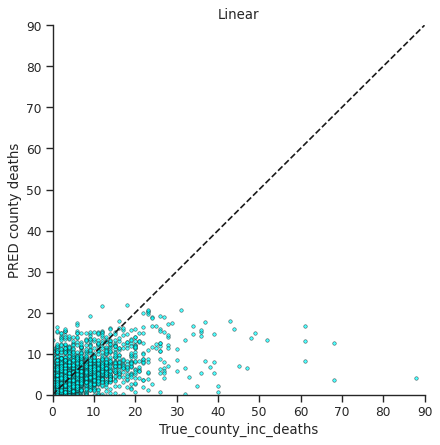

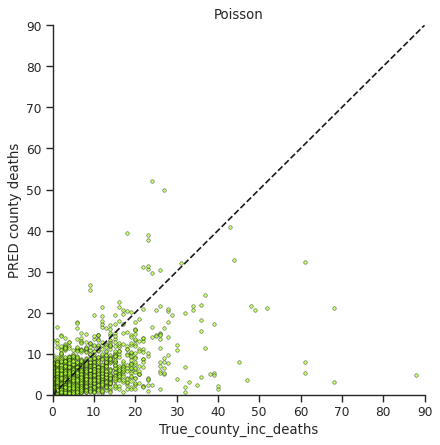

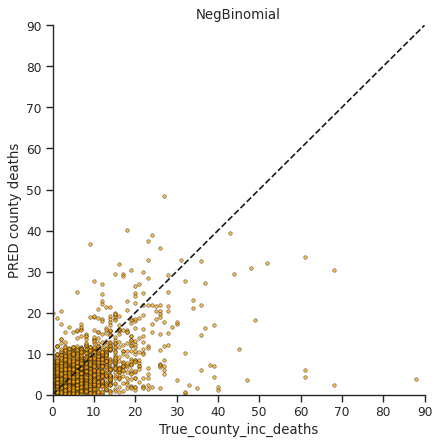

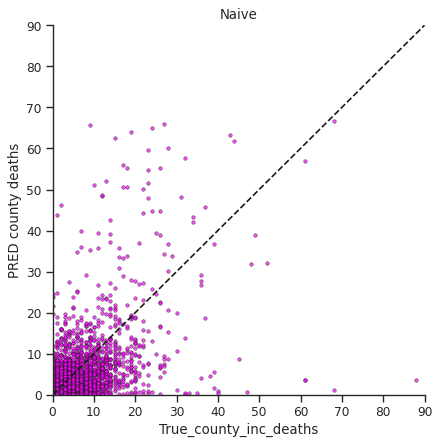

In [43]:
for alg,c in zip(my_algs,['aqua','greenyellow','orange','magenta']):
    figsize = (8,6)
    alpha = 0.7
    size = 10
    linewidth = .5

    DPI = 80
    FIGSIZE = (6,6)
    plt.figure(figsize=FIGSIZE)

    to_plot = df_full_res[df_full_res.Algorithm==alg]
    sns.scatterplot(data=to_plot, x='True_county_inc_deaths', y='PRED county deaths', alpha=alpha, 
                    linewidth=linewidth, edgecolors='k', s=size, color=c)
    plt.plot([0, 90], [0, 90],linestyle='--', color='k')

    sns.despine()
    plt.title(alg)
    plt.xlim((0, 90))
    plt.ylim((0, 90))    
    plt.gcf().set_dpi(DPI)
    plt.show()    